### Neuron Model
**The microcircuits of striatum in silico**

### modeling step
1) experimental data acquisition
2) morphological reconstruction and optimization 
3) placement of the neurons and synapse prediction in silico
4) constraining the synaptic properties and generating input model 
5) simulating the microcircuit

In [1]:
pip install neuron

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as pltㅋ
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


In [3]:
# Load neuron parameters from JSON file
"""
with open('/Users/tacolab4/Desktop/neuroscience/code/dSPN.json') as f:
    parameters = json.load(f)
"""

"\nwith open('/Users/tacolab4/Desktop/neuroscience/code/dSPN.json') as f:\n    parameters = json.load(f)\n"

In [4]:
### SPN Neuron Model 
# the striatal poplution 
# model: quadratic integrate and fire model neurons 
# D1(SD1) - dSPN, D2 - iSPN

# Load neuron parameters from JSON file
"""
with open('/Users/tacolab4/Desktop/neuroscience/code/dSPN.json') as f:
    parameters = json.load(f)
    
# Convert parameters to brian2 units
parameters['C_m'] = parameters['C_m'] * br.pF
parameters['t_ex'] = parameters['t_ex'] * br.ms
parameters['t_in'] = parameters['t_in'] * br.ms
parameters['E_L_ex'] = parameters['E_L_ex'] * br.mV
parameters['E_L_in'] = parameters['E_L_in'] * br.mV
parameters['E_L'] = parameters['E_L'] * br.mV
parameters['I_e'] = parameters['I_e'] * br.pA
parameters['a'] = parameters['a'] * br.nS
parameters['b'] = parameters['b'] * br.pA
parameters['tau_w'] = parameters['tau_w'] * br.ms
parameters['V_th'] = parameters['V_th'] * br.mV
parameters['Delta_T'] = parameters['Delta_T'] * br.mV
parameters['V_reset'] = parameters['V_reset'] * br.mV
parameters['V_peak'] = parameters['V_peak'] * br.mV
parameters['t_ref'] = parameters['t_ref'] * br.ms
parameters['tau_syn_ex'] = parameters['tau_syn_ex'] * br.ms
parameters['tau_syn_in'] = parameters['tau_syn_in'] * br.ms
parameters['V_ext'] = parameters['V_ext'] * br.mV
parameters['g_L'] = 10* br.nS
"""
Delta_T = 16.0 * br.mV
V_th = -29.7 * br.mV
g_L = 10 * br.nS
C_m = 15.2 * br.pF
E_L = 78.2 * br.mV
I_e = 0.0 * br.pA
V_peak = 40.0 * br.mV
V_reset = -51.0 * br.mV
b = 67.0 * br.pA
a = -20.5 * br.nS
tau_w = 1.0 * br.ms 

### Quadratic Integrate and Fire

- V: membrane potential 
- u: neuron's slow current
- I<sub>spon</sub>: 뉴런 내부의 활동 반영 (represents the intrinsic spontaneous current with the neuron)
- I<sub>stim</sub>: externally applied stimulus current, which in this context would include the cortical input
- I<sub>syn</sub>: This current arises from synaptic inputs received by the neuron from other neurons within the network (include GABAergic inputs, Glutamatergic inputs)

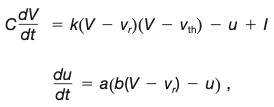

INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl/var
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl/var/folders
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl/var/folders/gc
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_zx7dbgrl
INFO:root:arm64-apple-darwin20.0.0-clang -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-stron

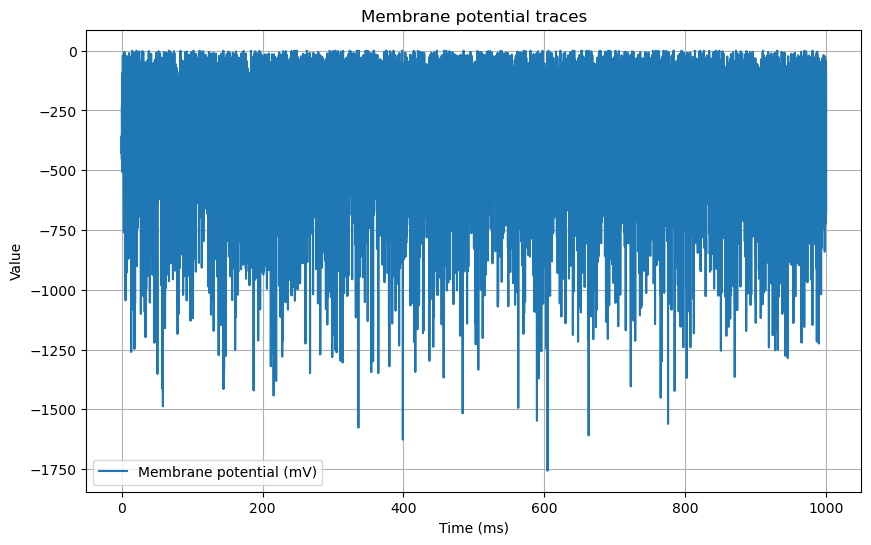

In [ ]:
### SPN Neuron Model 
# the striatal poplution 
# model: quadratic integrate and fire model neurons 
# D1 - dSPN (inhibitory), D2 - iSPN (excitatory)
# Fountas, Zafeirios. "Action selection in the rhythmic brain: The role of the basal ganglia and tremor." PhD Thesis, Imperial College London (2016).

a = 0.01 * br.ms
b = -20 * br.ms
c = -55 * br.mV
d = 91 * br.mV / br.ms
vpeak = 4. * br.mV
vr = -80 * mV
vt = -29.7 * br.mV
C = 15.2 * br.pF 
v = -80 * br.mV
u = 0.0 * br.mV
Ispon = 0.0 * br.mV
K = 0.0289
L = 0.331

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014
        
sigma_msn = 14.0 * br.mV # Fountas 2016

def Neuron_dSPN(N):

    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C + sigma_msn*xi/ms**.5 : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop1) : volt
    K = k*(1-ALPHA*Dop2) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn : amp
    Dop1      : 1
    Dop2      : 1
    '''

    dSPN = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    E_L = -74.2 * br.mV
    dSPN.v = E_L 
    ##dSPN.g_ex = 0 * br.siemens
    #dSPN.g_in = 0 * br.siemens
    #dSPN.w = 0 * br.amp
    #dSPN.ex_input = 0 * br.second
    #dSPN.in_input = 0 * br.second
    return dSPN

N = 10000
dSPN_group = Neuron_dSPN(N)

# Run the simulation
simulation_time = 1000 * ms
defaultclock.dt = 0.1 * ms  # Set the integration time step
run(simulation_time)

# Extract membrane potential traces
v = dSPN_group.v / mV

# Generate the time array
t = np.arange(0, simulation_time / ms, defaultclock.dt / ms)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, v, label='Membrane potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.title('Membrane potential traces')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def Neuron_iSPN(N):
    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop2) : volt
    K = k*(1-ALPHA*Dop1) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn    : amp
    Dop1    : 1
    Dop2    : 1
    '''
# not consider sigma_msn

    iSPN = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    E_L = -74.2 * mV
    iSPN.v = E_L 
    
    return iSPN

In [7]:
### Load synaptic parameter
data = dict()
data["MSN"] = dict()
data["MSN"]["tau"] = {
    "AMPA" :   { "value" : 6 * ms, "unit" : "ms"},
    "NMDA" :   { "value" : 160 * ms, "unit" : "ms"},
    "GABA" :   { "value" : 4 * ms, "unit" : "ms"}
}
data["MSN"]["E"] = {
    "AMPA" :   { "value" : 0 * mV, "unit" : "mV"},
    "NMDA" :   { "value" : 0 * mV, "unit" : "mV"},
    "GABA" :   { "value" : -60 * mV, "unit" : "mV"},
}
data["MSN"]["G"] = {
    "Ctx-MSN" : {
        "AMPA":   { "value" : 0.6, "unit" : "nS"},
        "NMDA":   { "value" : 0.3, "unit" : "nS"},
        "GABA":   { "value" : 0.0, "unit" : "nS"},
    },
    "MSN-MSN" : {
        "AMPA":   { "value" : 0.0, "unit" : "nS"},
        "NMDA":   { "value" : 0.0, "unit" : "nS"},
        "GABA":   { "value" : 0.75, "unit" : "nS"},
    },
    "FSI-MSN" : {
        "AMPA":   { "value" : 0.0, "unit" : "nS"},
        "NMDA":   { "value" : 0.0, "unit" : "nS"},
        "GABA":   { "value" : 3.75, "unit" : "nS"},
    }
}

In [8]:
data['MSN']['G']['MSN-MSN']['AMPA']['value']

0.0

In [9]:
### Generate Synapse 
connect_probability = {
    'pSP1SP1': 0.26,
    'pSP1SP2': 0.06,
    'pSP2SP1': 0.28,
    'pSP2SP2': 0.36,      
}

# 함수 저장
model_functions = {
    'Neuron_dSPN': Neuron_dSPN,
    'Neuron_iSPN': Neuron_iSPN,
}

g_gaba_MSN = data['MSN']['G']['MSN-MSN']['AMPA']['value']

In [10]:
connect_probability.get('pSP1SP1')

0.26

In [11]:
### Synapse Connection
# Hjorth, JJ Johannes, et al. "The microcircuits of striatum in silico." Proceedings of the National Academy of Sciences 117.17 (2020): 9554-9565.

def connect(source, target, p_connect=0.1, weight=-1*mV):
    model = '''
    w : 1
    '''
    # dg_syn/dt = -g_syn / tau_syn : siemens (clock-driven)
    # s = int(v_pre > theta_syn) : 1 
    # I_syn_post = g_syn * s * (v_post - E_syn) : amp (summed)
    synapse = Synapses(source, target, model=model, on_pre=f'v_post += w')
    synapse.connect(p=p_connect)
    synapse.w = weight
    return synapse

# 뉴런 그룹 생성
N = 10000
tau_syn = 5 * ms
theta_syn = -50 * mV
E_syn = -80 * mV

#dSPN = model_functions['Neuron_dSPN'](N * 0.45)
dSPN = Neuron_dSPN(N * 0.45)
iSPN = Neuron_iSPN(N * 0.45)
#iSPN = model_functions['Neuron_iSPN'](N * 0.45)

syn_eqs = '''
w : 1
dg_syn/dt = -g_syn / tau_syn : siemens (clock-driven)
s = int(v_pre > theta_syn) : 1 
I_syn_post = g_syn * s * (v_post - E_syn) : amp (summed)
'''

syn_dSPN_dSPN = connect(dSPN, dSPN, p_connect = connect_probability.get('pSP2SP1'), weight=0.4)
syn_dSPN_iSPN = connect(dSPN, iSPN, p_connect = connect_probability.get('pSP1SP2'), weight=1)
syn_iSPN_dSPN = connect(iSPN, dSPN, p_connect = connect_probability.get('pSP2SP1'), weight=1.2)
syn_iSPN_iSPN = connect(iSPN, iSPN, p_connect = connect_probability.get('pSP2SP1'), weight=1)

In [12]:
### Input value

def generate_cortex_input(duration, dt):
    t = np.arange(0, duration, dt)  # 시간 배열 생성
    input_values = np.ones_like(t) * 20  # 기본 값으로 초기화
    
    spike_time = 50 
    spike_duration = 20
    spike_value = 90

    spike_indices = np.logical_or(t >= spike_time, t < spike_time + spike_duration)
    for i in range(min(spike_time, len(input_values)), min(spike_time + spike_duration, len(input_values))):
        input_values[i] = spike_value
            
    return t * ms, input_values

In [13]:
defaultclock.dt = 1 * ms  # 시뮬레이션 시간 단계 설정
duration = 10000 * ms  # 시뮬레이션 시간 설정
t, cortex_input = generate_cortex_input(duration, defaultclock.dt)

WARNING    't' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value array([  0.,   1.,   2., ..., 997., 998., 999.]) * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ispon' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 10. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -20. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongro

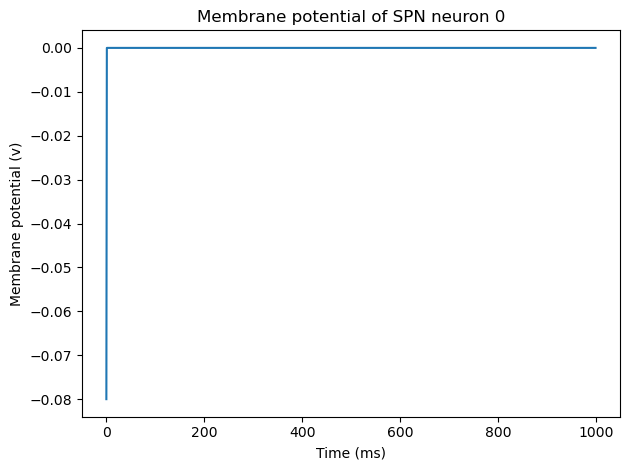

In [14]:
### Simulation

start_scope()

# Input
defaultclock.dt = 1 * ms  # 시뮬레이션 시간 단계 설정
duration = 1000 * ms  # 시뮬레이션 시간 설정

t, cortex_input = generate_cortex_input(duration, defaultclock.dt)
input_current = TimedArray(cortex_input * nA, dt=defaultclock.dt)
# iSPN.Istim = input_current
iSPN.v = vr
iSPN.Istim = 70 * nA  # Set a constant input current to ensure spiking

# Run Network
iSPN.run_regularly('Istim = input_current(t)', dt=defaultclock.dt)
state_mon_iSPN = StateMonitor(iSPN, 'v', record=True)
spike_mon_iSPN = SpikeMonitor(iSPN)  # SpikeMonitor 추가
net = Network(dSPN, iSPN, state_mon_iSPN)
net.run(duration)

# Membrane potential plot
plt.plot(state_mon_iSPN.t/ms, state_mon_iSPN.v[0])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (v)')
plt.title('Membrane potential of SPN neuron 0')

plt.tight_layout()
plt.show()

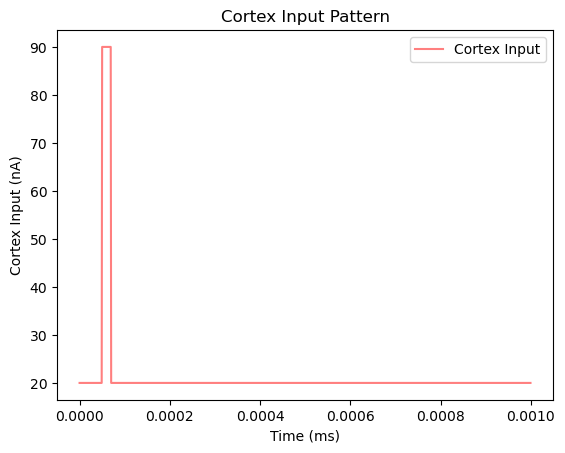

In [15]:
# Cortex 입력 패턴 시각화
plt.plot(t, cortex_input, 'r', alpha=0.5, label='Cortex Input')
plt.xlabel('Time (ms)')
plt.ylabel('Cortex Input (nA)')
plt.title('Cortex Input Pattern')
plt.legend()

### Future Work
### paper: **Dopamine depletion leads to pathological synchronization of distinct basal ganglia loops in the beta band**

- point neurons: adaptive exponential neuron model 
- SNr model

<img src = "./eqs1.png" width = "600" height = "80">

- excitatory and inhibitory conductance present exponential decays

<img src = "./eqs2.png" width = "300" height = "100">

- evolution of the adaptation variable w 

<img src = "./eqs3.png" width = "400" height = "100">